In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import chainer
from chainer.dataset import convert
import cv2
import net_conv
import hickle as hkl

/Users/Atsushi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
X = hkl.load('X_train.hkl')
X = X / 255.
X = X.astype('float32')
sources = hkl.load('sources_train.hkl')

In [5]:
X2 = hkl.load('X_val.hkl')
X2 = X2 / 255.
X2 = X2.astype('float32')
sources2 = hkl.load('sources_val.hkl')

In [7]:
X3 = hkl.load('X_test.hkl')
X3 = X3 / 255.
X3 = X3.astype('float32')
sources3 = hkl.load('sources_test.hkl')

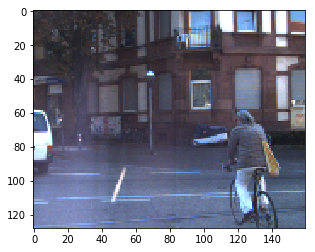

In [8]:
plt.imshow(X[0])

In [68]:
N = X[0].shape[0]
N2 = X[0].shape[1]
gpu = -1
dimz = 2
batchsize = 16
epoch = 20
initmodel = ''
resume = ''
out = 'result/KITTI'
is_test = False #'store_true'

In [42]:
print('GPU: {}'.format(gpu))
print('# dim z: {}'.format(dimz))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(epoch))
print('')

GPU: -1
# dim z: 2
# Minibatch-size: 16
# epoch: 10



In [43]:
# Initialize / Resume
if initmodel:
    chainer.serializers.load_npz(initmodel, model)
if resume:
    chainer.serializers.load_npz(resume, optimizer)

In [45]:
train = list()
for idx in range(len(X)-1):
    if sources[idx] == sources[idx+1]:
        train.append((np.transpose(X[idx], (2,0,1)), np.transpose(X[idx+1], (2,0,1))))

In [46]:
len(train)

153

In [47]:
test = list()
for idx in range(len(X2)-1):
    if sources2[idx] == sources2[idx+1]:
        test.append((np.transpose(X2[idx], (2,0,1)), np.transpose(X2[idx+1], (2,0,1))))

In [48]:
len(test)

153

In [44]:
test_for_plot = list()
for idx in range(len(X3)-1):
    test_for_plot.append(np.transpose(X3[idx], (2,0,1)))

In [49]:
random.shuffle(train)
random.shuffle(test)

In [50]:
if is_test:
    train, _ = chainer.datasets.split_dataset(train, 100)
    test, _ = chainer.datasets.split_dataset(test, 100)
train_count = len(train)
test_count = len(test)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [51]:
model = net_conv.ConvAE_mini(input_size=N, input_size2=N2, channel_size=3, n_filters=10, n_latent=dimz, filter_size=3, activation='relu')

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [52]:
c = 1
while train_iter.epoch < epoch:
    sum_loss = 0
    batch = train_iter.next()
    x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
    x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
    x = chainer.Variable(x_array1)
    # Update model based on the loss function
    # defined by model.get_loss_func()
    optimizer.update(model.get_loss_func(), x, x_array2)
    sum_loss += float(model.loss.data) * len(x.data)
    if train_iter.is_new_epoch:
        print(c)
        c += 1
        print('train mean loss={}'.format(sum_loss / train_count))
        # evaluation
        sum_loss = 0
        for batch in test_iter:
            x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
            x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
            x = chainer.Variable(x_array1)
            loss_func = model.get_loss_func(k=10)
            loss_func(x, x_array2)
            sum_loss += float(model.loss.data) * len(x.data)
        test_iter.reset()
        print('test mean loss={}'.format(sum_loss / test_count))

1
train mean loss=4602.180147058823
test mean loss=43788.94344873366
2
train mean loss=4478.464460784314
test mean loss=42610.201848447716
3
train mean loss=4418.3758169934645
test mean loss=42086.16133067811
4
train mean loss=4322.297385620915
test mean loss=41355.66184129902
5
train mean loss=4238.895833333333
test mean loss=40550.466554330065
6
train mean loss=4094.669117647059
test mean loss=39448.8284058415
7
train mean loss=4080.524509803922
test mean loss=38730.15688827614
8
train mean loss=4027.7442810457514
test mean loss=37962.032194648695
9
train mean loss=3903.3218954248364
test mean loss=37203.72949857026
10
train mean loss=3785.090277777778
test mean loss=36515.36782577614


In [18]:
# Save the model and the optimizer
print('save the model')
chainer.serializers.save_npz(os.path.join(out, 'model.model'), model)
print('save the optimizer')
chainer.serializers.save_npz(os.path.join(out, 'state.state'), optimizer)

save the model
save the optimizer


In [53]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(np.transpose(xi, (1,2,0)))
    fig.savefig(filename)

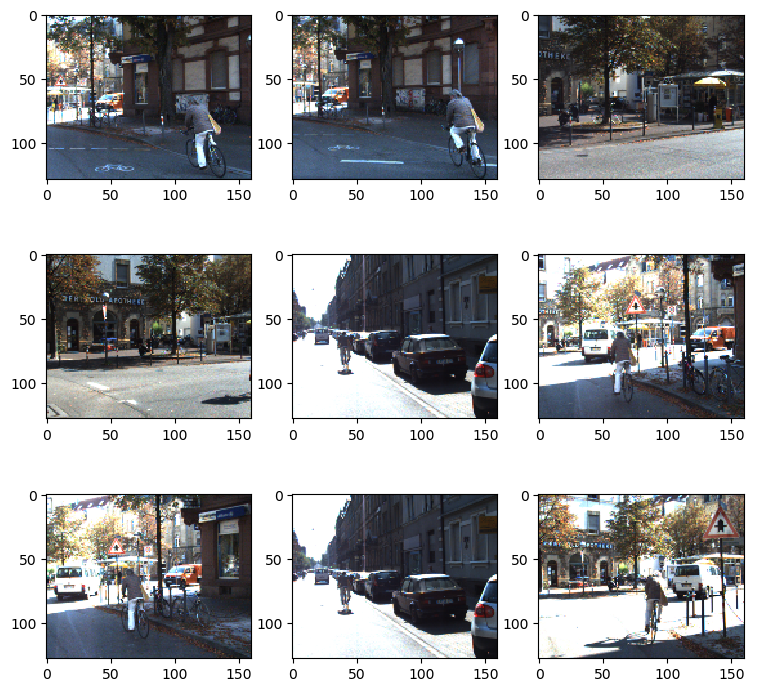

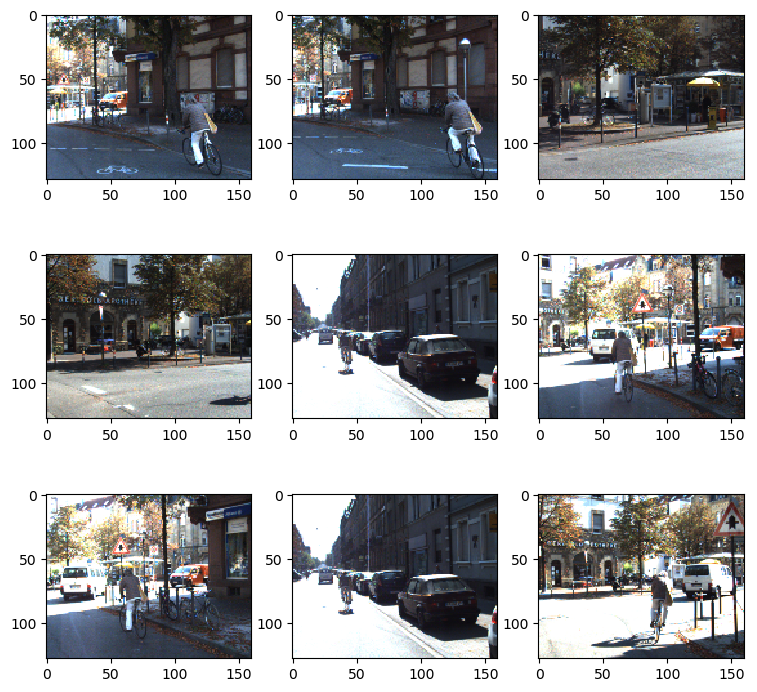

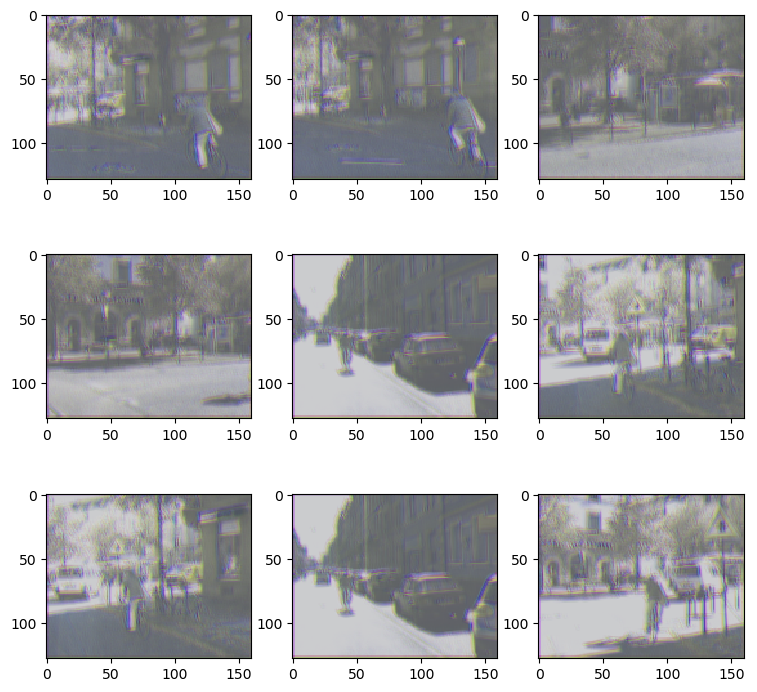

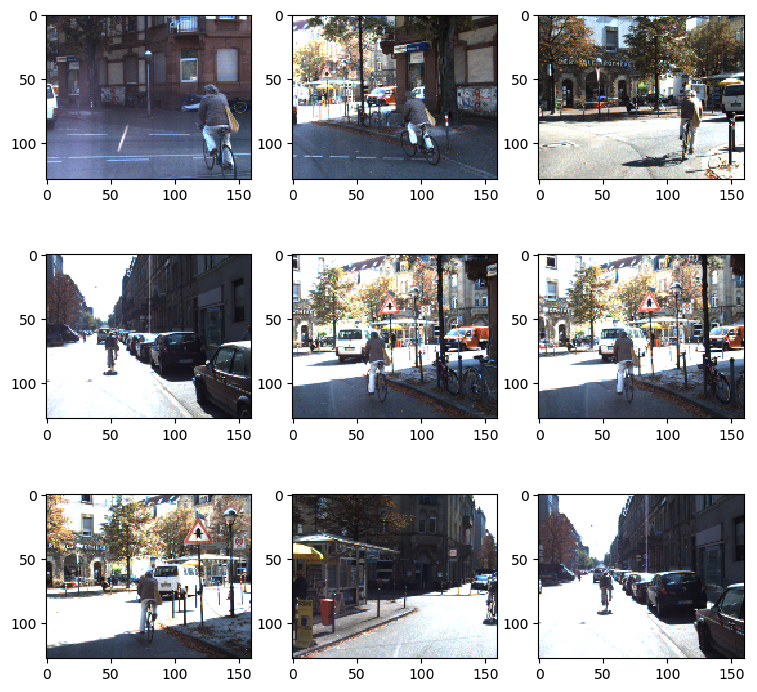

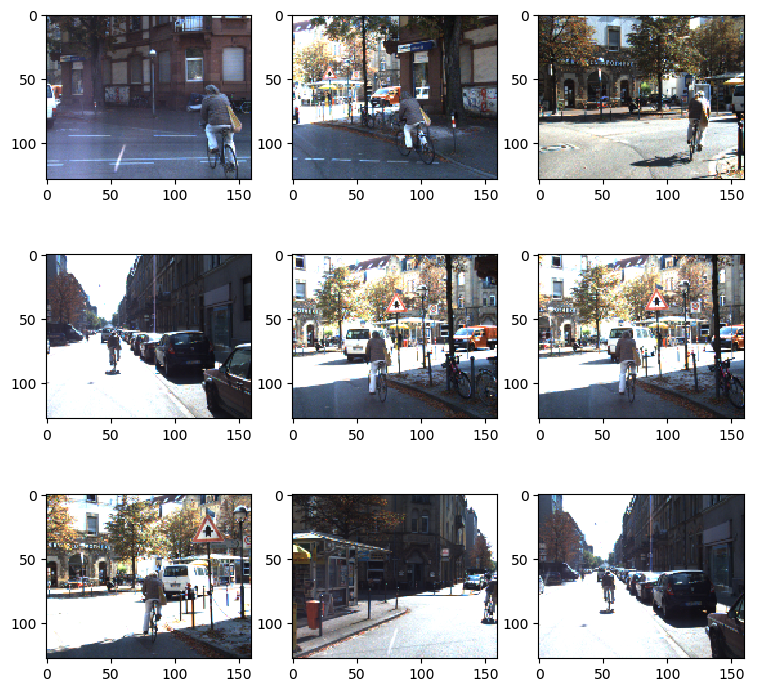

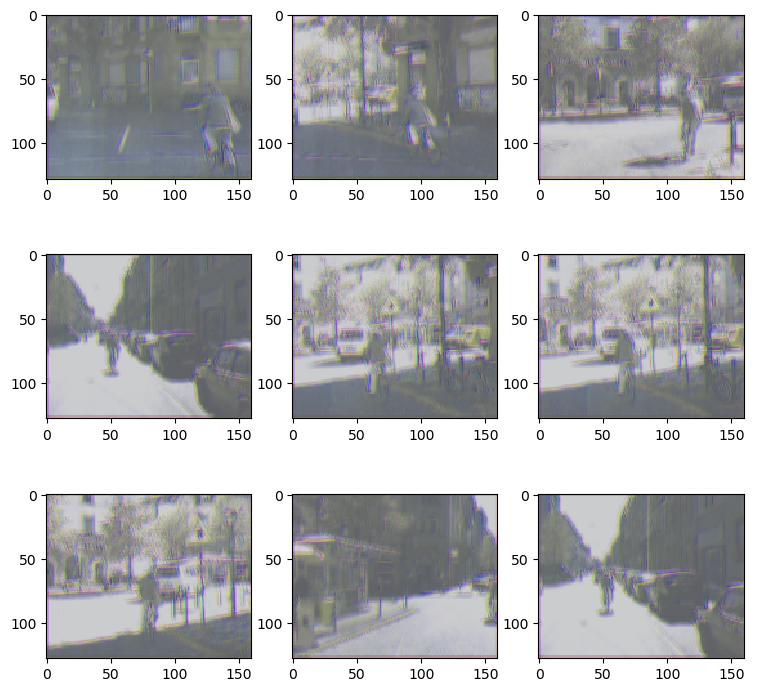

In [54]:
model.to_cpu()
train_ind = np.random.randint(0,len(train),9)
# train_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(train)[train_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'train_x'))
save_images(x_array2, os.path.join(out, 'train_xnext'))
save_images(x1.data, os.path.join(out, 'train_xnextreconstructed'))

# test_ind = np.random.randint(0,len(test),9)
test_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(test)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'test_x'))
save_images(x_array2, os.path.join(out, 'test_xnext'))
save_images(x1.data, os.path.join(out, 'test_xnextreconstructed'))


plot for paper (same format with Prednet)

In [55]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.gridspec as gridspec

In [56]:
len(test_for_plot)

19

In [57]:
# test_ind = [0,1,2,3,4,5,6,7,8,9]
test_ind = list(np.linspace(0, len(test_for_plot)-2, len(test_for_plot)-1, dtype='int32'))
batch = np.asarray(test_for_plot)[test_ind]
# test_ind = list(np.linspace(0, 9, 10, dtype='int32'))
# batch = np.asarray(test_for_plot_glider)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x, batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

In [74]:
x_array1.transpose(0,2,3,1).shape

(18, 128, 160, 3)

In [72]:
N2

160

In [75]:
X_test = x_array1[:10].transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, N, N2, 3)
X_hat = x1.data[:10].transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, N, N2, 3)

In [76]:
X_test.shape

(1, 10, 128, 160, 3)

In [77]:
nt = 10
aspect_ratio = 0.8
# plt.figure(figsize = (nt, 2*aspect_ratio))
plt.figure(figsize = (100/7.2, 16/7.2))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = 'fig_for_paper/KITTI/'
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])

for i in plot_idx:
    for t in range(nt):     
        plt.subplot(gs[t])
        plt.imshow(X_test[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        if t % 10 == 0:
            plt.imshow(np.zeros(X_hat[0,0].shape), interpolation='none')
        else:
            plt.imshow(X_hat[i,t-1], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
    
    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()
plt.close()

/Users/Atsushi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [62]:
mse_model = 0
mse_prev = 0
c = 0
for i in range(len(X_test)):
    for j in range(len(X_test[0])-1):
        mse_model += np.mean((X_test[i,j+1,:,:] - X_hat[i,j,:,:])**2)
        mse_prev += np.mean((X_test[i,j+1,:,:] - X_test[i,j,:,:])**2)        
        c += 1

In [63]:
mse_model/c

0.06793821189138624

In [64]:
mse_prev/c

0.029622284695506096